In [1]:
#import libs
import sys,os
import numpy as np

os.chdir(r'G:\My Drive\Documents\PhD\Modelling\_RiceBall')
from ricepaper.material import NodeSet
from ricepaper import RicePaper
from ricepaper.utils import *


In [2]:
#define a material
mat = NodeSet("SlopeStability",[15,10,10], #radii
                         2500, #densities (applied to all radii)
                         6.96e9, #young's modulus (applied to all radii)
                         0.2) #poisson ratio (applied to all radii)
mat.setFriction(0.3, #friction coefficient
                2.5e6) #2.5 MPa cohesion
mat.setBonding( 5e9, #normal stiffness (Pa)
                5e9, #shear stiffness (Pa)
                5e6, #tensile strength (Pa)
                10e6) #shear strength (Pa)

In [3]:
#generate pile
R = mat.gravityDeposit(750,1500,base=3000, stepSize=200, walltype=3,suppress=True)

Generating 568 particles in layer 0
Generating 568 particles in layer 1
Generating 568 particles in layer 2
Generating 568 particles in layer 3
Average kinetic energy = 1.287157E+08
Average kinetic energy = 2.538772E+07
Average kinetic energy = 5.169690E+06
Average kinetic energy = 1.234221E+06
Average kinetic energy = 1.080562E+05
Average kinetic energy = 1.742671E+05
Average kinetic energy = 1.458073E+04
Average kinetic energy = 1.362153E+03
Average kinetic energy = 1.138347E-04
Model equilibrated


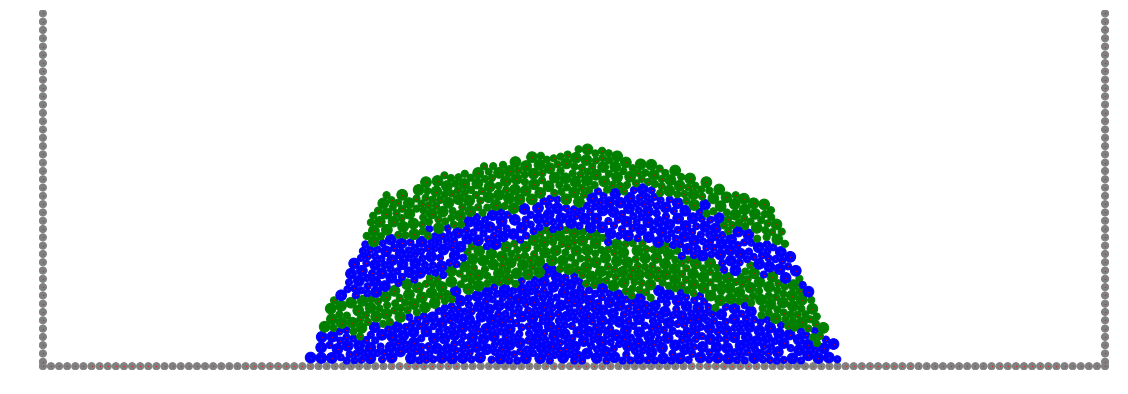

In [4]:
#shape pile
slope = 65 #slope of sculpted pile
height = 1000 #height of sculpted pile
xmin = 1200 - height / np.tan( np.deg2rad(slope) )
xmax = 1800 + height / np.tan( np.deg2rad(slope) )

pile= R.loadLastOutput()
deleted = pile.cut(xmin,slope)
deleted += pile.cut(xmax,-slope)

pile.quickPlot()

In [5]:
#delete balls from model
R.delBalls(deleted,pile.pos)

#cycle for 25 x 5 second timesteps
steps = []
for i in range(25):
    steps.append(R.cycle(5))

success = R.execute(suppress = False)

RiceBall execution finished in 2.12 minutes.


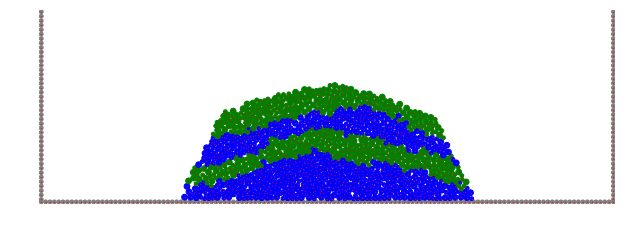

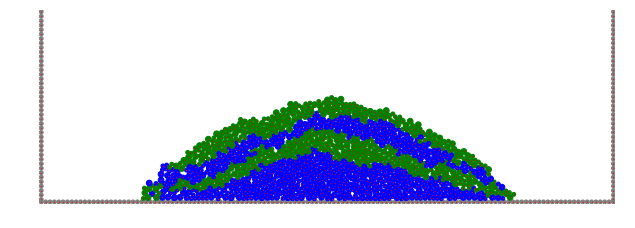

In [6]:
M = R.loadSteps(steps)
M[0].quickPlot(figsize=(8,5))
M[-1].quickPlot(figsize=(8,5))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


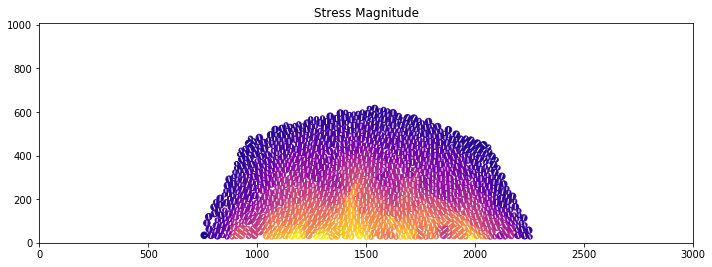

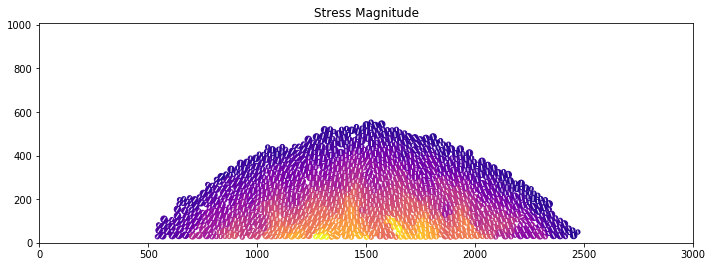

In [7]:
#plot initial and final stresses
M[0].averageAttr("stress", n = 5)
M[-1].averageAttr("stress", n = 5)

fig,ax=M[0].plotAttr("stress", func="mag", title="Stress Magnitude")
fig,ax=M[-1].plotAttr("stress", func="mag", title="Stress Magnitude")

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
G:\My Drive\Documents\PhD\Modelling\_RiceBall\ricepaper\reader.py:952: RuntimeWarning: invalid value encountered in true_divide
  ticks.append( v2d / np.linalg.norm(v2d) ) #store normalised tick
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


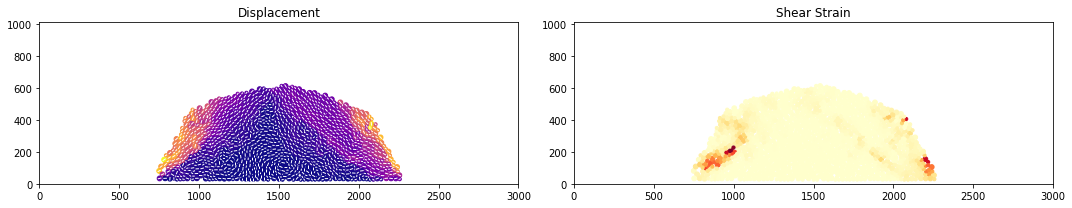

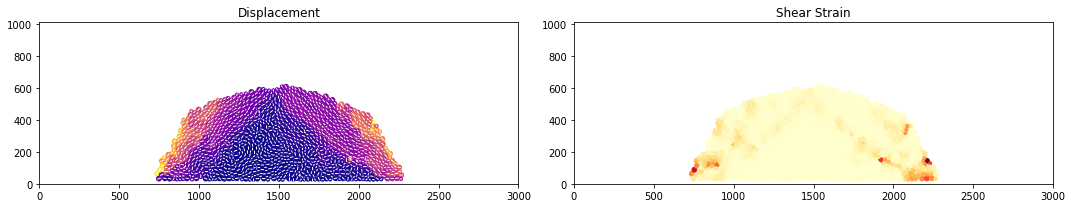

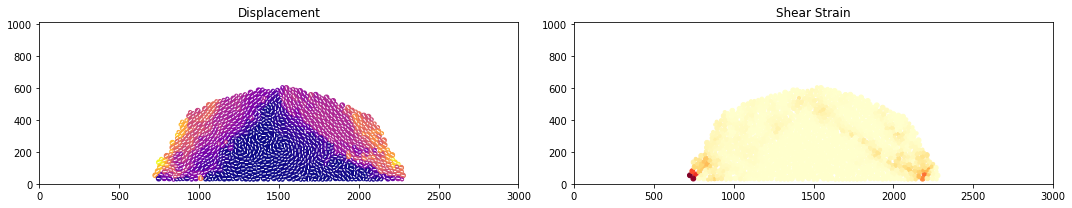

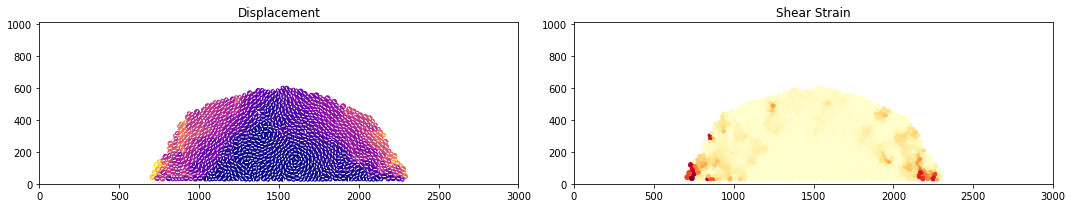

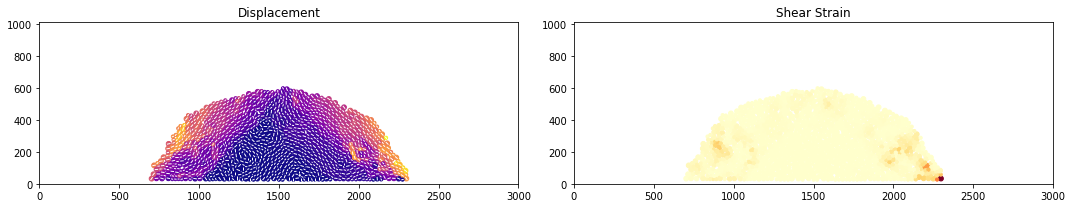

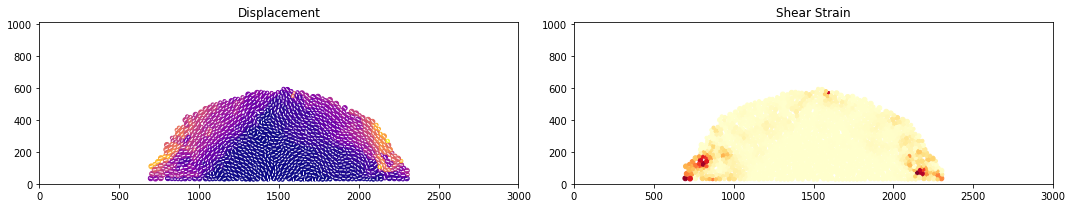

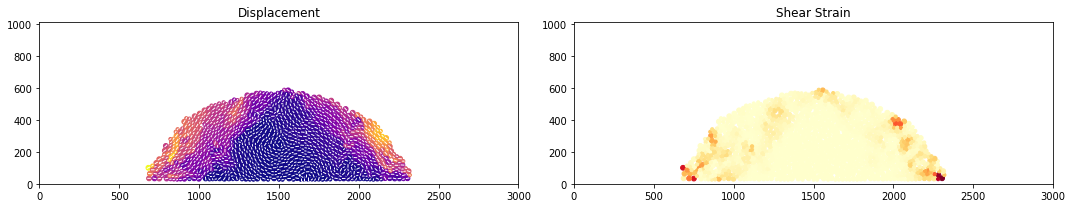

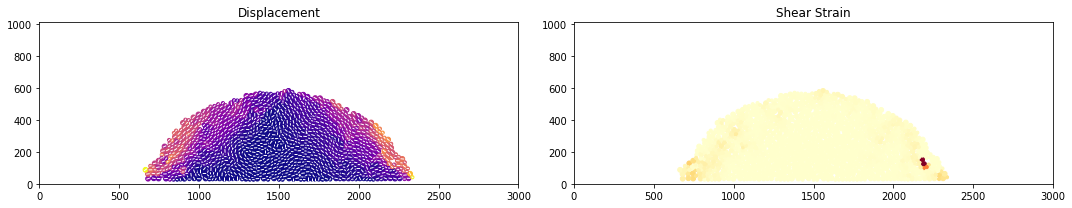

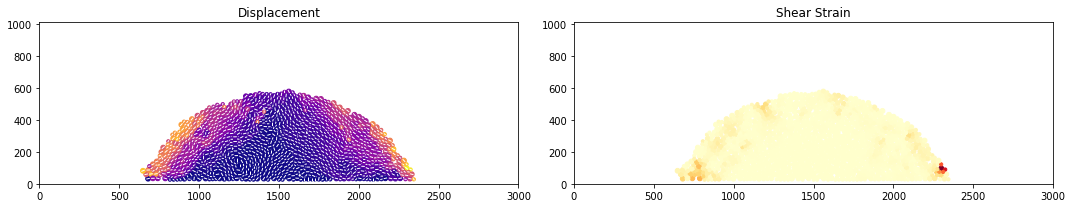

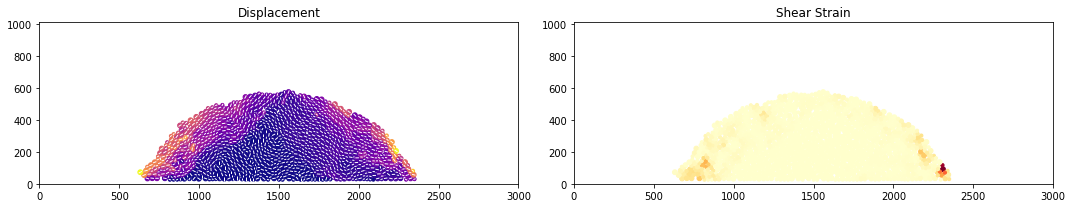

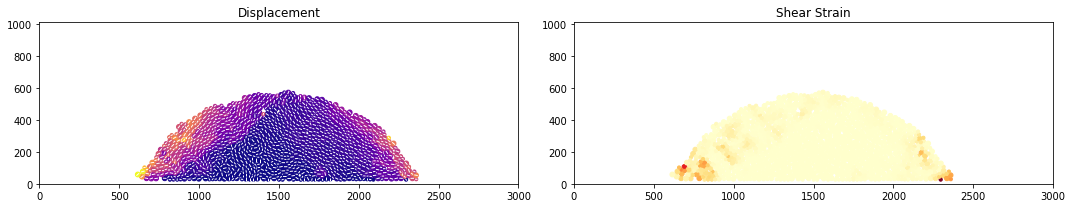

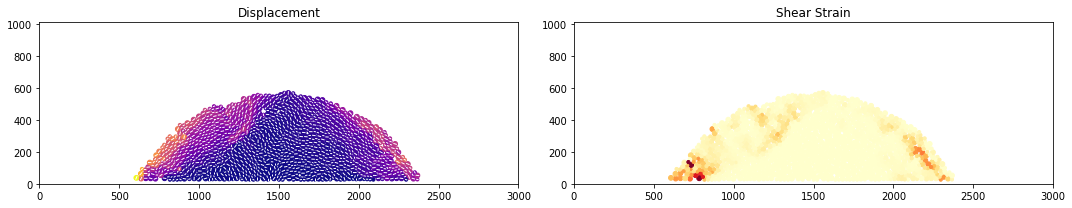

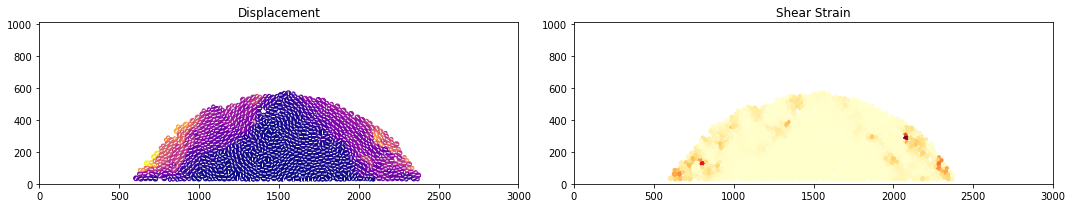

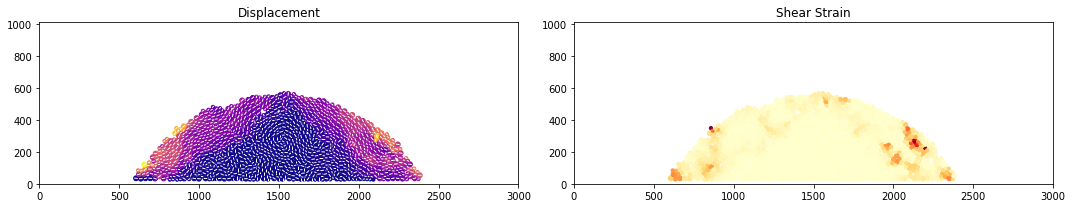

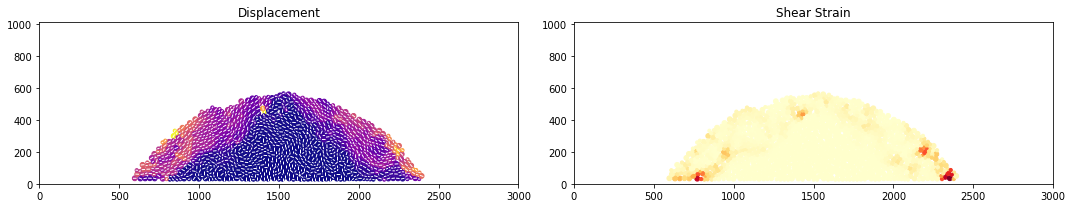

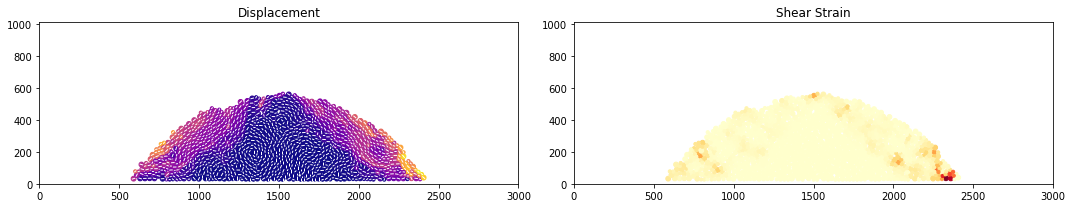

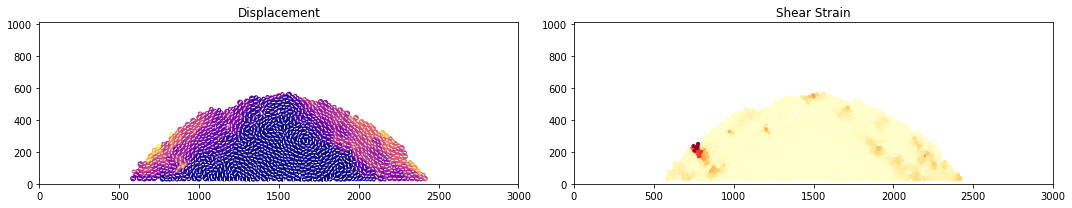

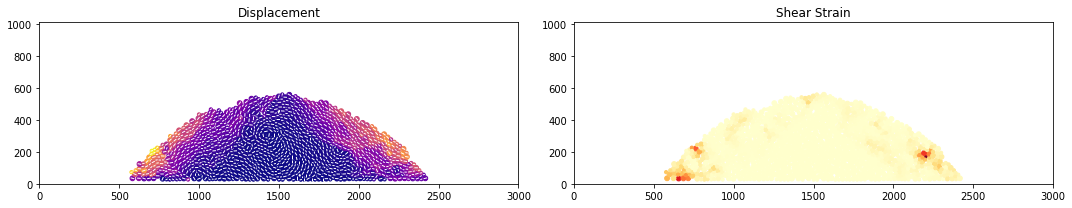

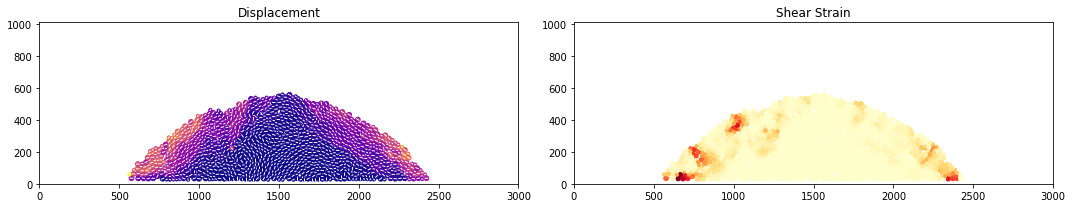

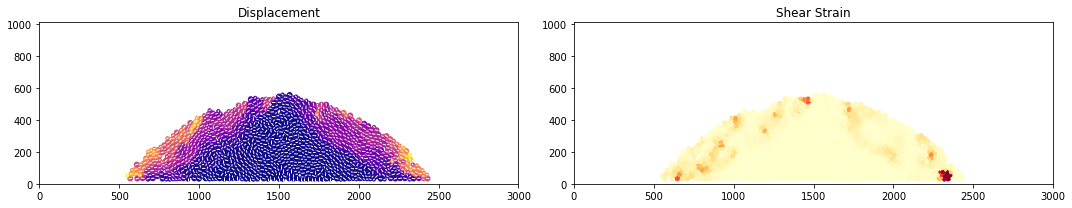

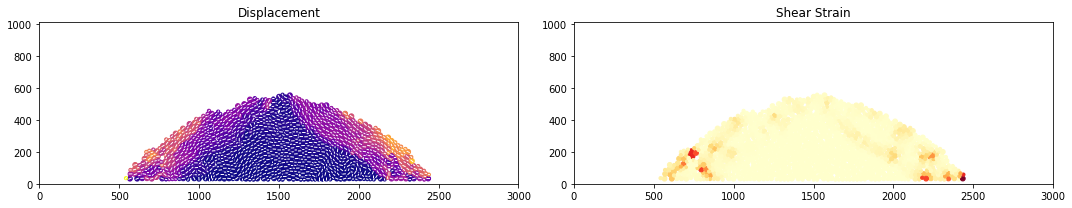

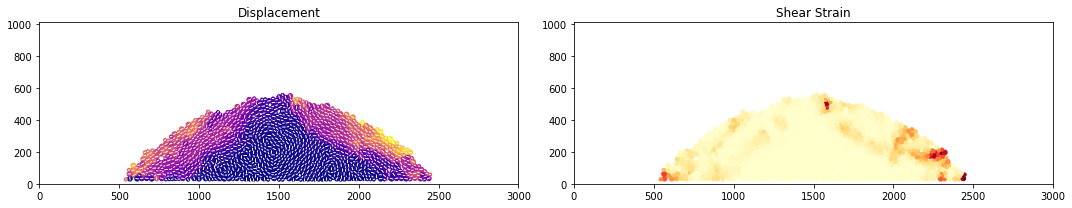

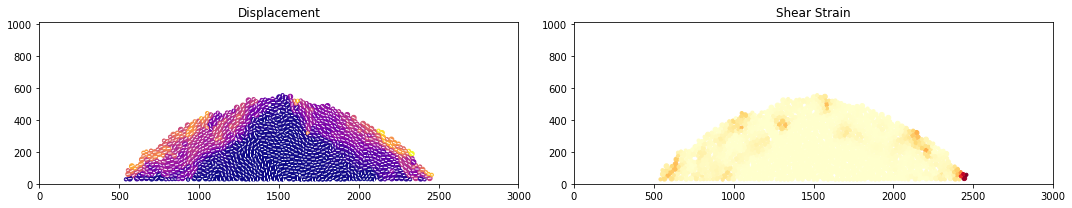

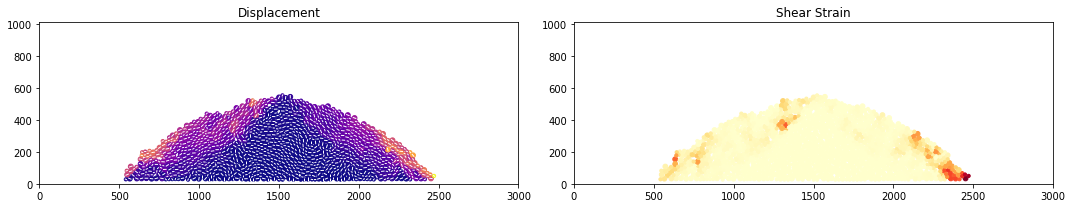

In [8]:
#compute strains and displacements and plot
for t in range(1,len(M)):
    
    #compute
    M[t].computeParticleDisplacements(M[t-1])
    M[t].computeStrain2D(M[t-1])
    
    #average strain
    M[t].averageAttr("strain",n=2)
    M[t].averageAttr("deviatoric_strain",n=2)
    
    #plot
    fig,ax = M[t].plotAttr(attr=["disp","deviatoric_strain"],func="inv2",
                           title=["Displacement","Shear Strain"],
                           linewidth = [1,0],
                           cmap = ['plasma','YlOrRd'],
                           figsize=(15,10))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


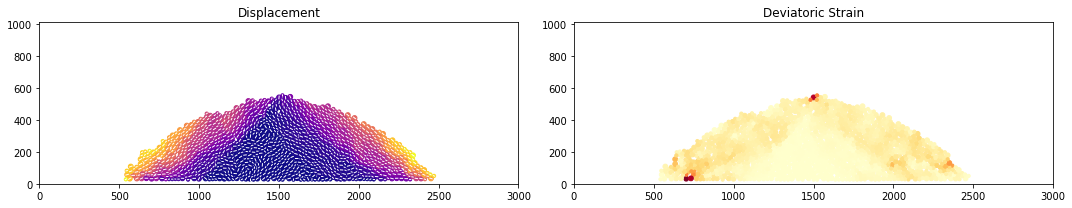

In [9]:
#and over the whole range
M[-1].computeParticleDisplacements(M[0])
M[-1].computeStrain2D(M[0])

#average strain
M[-1].averageAttr("strain",n=2)
M[-1].averageAttr("deviatoric_strain",n=2)

#plot
fig,ax = M[-1].plotAttr(attr=["disp","deviatoric_strain"],inv="mag",
                       title=["Displacement","Deviatoric Strain"],
                       linewidth = [1,0],
                       cmap = ['plasma','YlOrRd'],
                       figsize=(15,10))
